# Homework 7 Template

Rixin Li & G . Besla



In [1]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [2]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# import GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [3]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """ This function initiates all the values that will be used to calculate
        the velocity and position of M33 with respect to M31.
        
        INPUT:
            filename: string
                the name of the file where the eventual results will be saved.
        OUTPUT: none"""
        
        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### store the output file name
        self.filename = filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the CenterOfMass class for M33 
        M33_COM = CenterOfMass("M33_000.txt", 2)

        # store the position VECTOR of the M33 COM (.value to get rid of units)
        posM33 = M33_COM.COM_P(0.1)
        self.posM33 = posM33.value

        # store the velocity VECTOR of the M33 COM (.value to get rid of units)
        vecM33 = M33_COM.COM_V(*posM33)        
        self.vecM33 = vecM33.value
        
        ### get the current pos/vel of M31 
        # create an instance of the  CenterOfMass class for M31 
        M31_COM = CenterOfMass("M31_000.txt", 2)

        # store the position VECTOR of the M31 COM (.value to get rid of units)
        posM31 = M31_COM.COM_P(0.1)
        self.posM31 = posM31.value

        # store the velocity VECTOR of the M31 COM (.value to get rid of units)
        vecM31 = M31_COM.COM_V(*posM31)        
        self.vecM31 = vecM31.value        
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = self.posM33 - self.posM31
        self.v0 = self.vecM33 - self.vecM31
        
        ### get the mass of each component in M31 
        ### disk
        # self.rdisk = scale length (no units)
        self.rdisk = 5

        # self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass("M31_000.txt", 2) * 1e12
        
        ### bulge
        # self.rbulge = set scale length (no units)
        self.rbulge = 1

        # self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass("M31_000.txt", 3) * 1e12
        
        # Halo
        # self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62 

        # self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass("M31_000.txt", 1) * 1e12
    
    
    def HernquistAccel(self, M, r_a, r):
        """ This function uses the Hernquist profile to calculate the acceleration vector
        from a Hernquist potential. Can be applied to calculate the acceleration of the halo and bulge.
        INPUTS:
            M: float
                total mass, either of the bulge or the halo 
            r_a: float
                scale length corresponding to M
            r: NumPy array
                vector representing the x, y and z coordinates of the COM
        
        OUTPUT:
            Hern: NumPy array
                acceleration of a Hernquist potential
        """
        
        ### store the magnitude of the position vector
        rmag = np.sqrt(np.sum(r**2))
        
        ### store the Acceleration, following the formula from the HW instructions
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        Hern = -self.G*M/(rmag*(r_a + rmag)**2) * r
        return Hern
    
    def MiyamotoNagaiAccel(self, M, r_d, r): 
        """ This function uses the Miyamoto-Nagai profile to calculate the acceleration vector
        from a Miyamoto-Nagai potential. Can be applied to calculate the acceleration of the disk.
        INPUTS:
            M: float
                total mass of the disk
            r_d: float
                scale length corresponding to M
            r: NumPy array
                vector representing the x, y and z coordinates of the COM
        
        OUTPUT:
            accel: NumPy array
                acceleration of a Hernquist potential
        """
        
        # first, define z_d, which is relevant for the Miyamoto-Nagai profile
        z_d = r_d/5.0
        
        # next, retrieve the x, y and z coordinates from the r vector
        x = r[0]
        y = r[1]
        z = r[2]
        
        # finally, define some parameters for the Miyamoto-Nagai profile
        R = np.sqrt(x**2 + y**2)
        B = r_d + np.sqrt(z**2 + z_d**2)
        
        # this isn't in the paper, but is recommended by the instructions to clean up the code
        zstuff = B/np.sqrt(z**2 + z_d**2) 
        
        # finally, compute the acceleration from the Miyamoto-Nagai profile
        accel = (-self.G*M/((R**2 + B**2)**1.5)) * r * np.array([1, 1, zstuff])
       
        return accel
       
    
    def M31Accel(self, r): # input should include the position vector, r
        """ This function sums up all the acceleration vectors of a galaxy's components.
        INPUT:
            r: NumPy array
                vector representing the x, y, and z coordinates of the COM
                
        OUTPUT:
            accel_tot: NumPy array
                total acceleration of all galaxy components
        """

        # call the previous functions for the halo, bulge and disk. these functions will take as 
        # inputs variable we defined in the initialization of the class like self.rdisk etc. 
        halo_accel = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        bulge_accel = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        disk_accel = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        
        # compute and return the SUM of the output of the acceleration functions - this will return a VECTOR 
        accel_tot = halo_accel + bulge_accel + disk_accel
        return accel_tot
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """ This function uses the leapfrog method to integrate for the future position and velocity.
        INPUTS:
            dt: float
                time interval for integration
            r: NumPy array
                starting position for M33's COM position with respect to M31
            v: NumPy array
                starting position for M33 with respect to M31
        
        OUTPUTS:
            rnew: NumPy array
                position of M33's COM position one timestep after present
            vnew: NumPy array
                velocity of M33 one timestep after present"""
        
        # predict the position at the next half timestep
        rhalf = r + v*(dt/2)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew*(dt/2)

        # return the new position and velocity vectors
        return rnew, vnew
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ This function loops over the LeapFrog integrator to compute the future orbit of M33 
        10 Gyr into the future.
        INPUTS: 
            t0: float
                the input starting time
            dt: float
                time interval for integration
            tmax: float
                the final time
                
        OUTPUT: none
        """
        
        # initialize the position and velocity
        r = self.r0
        v = self.v0

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size: rows int(tmax/dt)+2, columns 7
        orbit = np.zeros((int(tmax/dt)+2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while t < tmax: # as long as t has not exceeded the maximal time 
            
            # advance the time by one timestep, dt
            t += dt
           
            # store the new time in the first column of the ith row
            orbit[i,0] = t
            
            # advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            rnew, vnew = self.LeapFrog(dt, r, v)

            # store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            orbit[i,1:4] = rnew
            
            # store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i,4:8] = vnew
            
            # update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
            
            # update r and v for the next loop
            r = rnew
            v = vnew
                                
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        print('it works!')

In [4]:
# Initiate an instance of the M33AnalyticOrbit class

M33_analysis = M33AnalyticOrbit('output.txt')
M33_analysis.OrbitIntegration(0, 0.001, 10)

it works!


In [5]:
# Next, read in the file that was just created in HW7
data_predict = np.genfromtxt('output.txt')
times = data_predict[:,0]
r = data_predict[:,1:4]
v = data_predict[:,4:]

In [6]:
# Next, find the position and velocity magnitudes of the predicted orbits.
# First, create empty arrays to save the magnitude values

r_magnitude = np.zeros(int(np.size(r)/3))
v_magnitude = np.zeros(int(np.size(v)/3))

i = 0
for r_snapshot in r:
    r_magnitude[i] = np.sqrt(np.sum(r_snapshot**2))
    i += 1
    
j = 0
for v_snapshot in v:
    v_magnitude[j] = np.sqrt(np.sum(v_snapshot**2))
    j += 1

### Now we copy-paste codes from Homework 6 to get the plot of M33's relative position and velocity over time. This will allow us to overplot as instructed.

In [7]:
# Read in the data files for the orbits of each galaxy as created in HW6
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt

dataM31 = np.genfromtxt('Orbit_M31.txt')
dataM33 = np.genfromtxt('Orbit_M33.txt')

In [8]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  

def VectorMagnitude(vec1, vec2):
    """This function computes the magnitude of the difference between two vectors.
    Inputs:
        vec1: NumPy array
            the first vector, given in its x, y, and z coordinates
        vec2: NumPy array
            the second vector, given in its x, y, and z coordinates
    
    Output:
        magdiff: scalar quantity
            the magnitude of the difference between vec1 and vec2
    """
    
    return np.sqrt(np.sum((vec1 - vec2)**2))

In [9]:
how_many_snapshots = int(np.size(dataM31) / 7) # 7 is the number of columns

# Determine the magnitude of the relative position and velocities 
# of M33 and M31
mag_pos_M33_M31 = np.zeros(how_many_snapshots)
mag_vec_M33_M31 = np.zeros(how_many_snapshots)

# this loops over every snapshot in the data arrays of both galaxies, finds each galaxy's 
# position & velocity vector and calculates the vector difference magnitude
for idx in range(0, how_many_snapshots):
    pos_M33 = dataM33[idx, 1:4]
    pos_M31 = dataM31[idx, 1:4]
    vec_M33 = dataM33[idx, 4:]
    vec_M31 = dataM31[idx, 4:]
    mag_pos_M33_M31[idx] = VectorMagnitude(pos_M33, pos_M31)
    mag_vec_M33_M31[idx] = VectorMagnitude(vec_M33, vec_M31)

In [10]:
# Determine the magnitude of the relative position and velocities 
# of M33 and M31
M33_M31_relpos = VectorMagnitude(pos_M31, pos_M33)
M33_M31_relvel = VectorMagnitude(vec_M31, vec_M33)

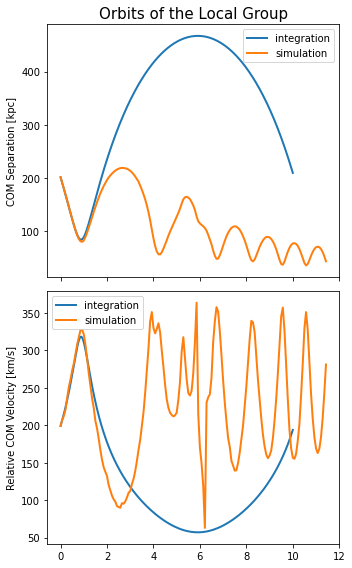

In [24]:
# Plot the Orbit of the galaxies 
#################################

fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

axes[0].set_title("Orbits of the Local Group", fontsize=15)

axes[0].plot(times, r_magnitude, label='integration', linewidth=2)
axes[0].plot(dataM31[:,0], mag_pos_M33_M31, label='simulation', linewidth=2)
axes[0].legend()
axes[0].set(ylabel='COM Separation [kpc]')

axes[1].plot(times, v_magnitude, label='integration', linewidth=2)
axes[1].plot(dataM31[:,0], mag_vec_M33_M31, label='simulation', linewidth=2)
axes[1].legend()
axes[1].set(ylabel='Relative COM Velocity [km/s]')

plt.tight_layout()
plt.show()

## Analysis

2. The plot of the simulation data looks way more jagged than the plot of the orbit integration. For the separation, the simulation data peaks far lower (\~200 kpc) than the integration (\~450 kpc), whereas for the velocity, the simulation's minimum is close to that of the integration (\~70 kpc).

3. The difference comes from the fact that we're assuming a constant Hernquist profile and a constant Miyamoto-Nagai profile. These profiles are only possible if all the dark matter and star particles do not interact with each other and amongst themselves, which is the cause of dynamical friction. Also, M31 has more than just M33 as its satellite galaxy. The combined interactions between M31 and all of its satellites will definitely affect the COM separation between M33 and M31, as well as the relative velocity between the two.

4. I'm not sure how to include the effects of the Milky Way, since it's too far away compared to the M31-M33 system. 